# RNNs for Ocean Swell Prediction

## Introduction

Ocean swell is formed by high winds over the open ocean and propagates globally for thousands of kilometers. Accurate nearshore swell prediction is desirable for many applications, from military operations to surfing. Data-driven models, such as recurrent neural networks (RNN), are a popular model for forecasting time series data. Here, different RNN architectures are applied to perform week-to-week swell prediction. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim


## Set up Device

Training on the GPU will be much faster.


In [4]:
CudaAvaliable = torch.cuda.is_available()
print(CudaAvaliable)
device = torch.device('cuda:0') if CudaAvaliable else torch.device('cpu')


True


## Import Training Data

The data provided by the NDBC is in the form of energy density spectra collected at [station 46024 ](https://www.ndbc.noaa.gov/station_page.php?station=46042) off the coast of California, plotted below in a contour plot. Light blue lines are swell events. This evolution is what the model should predict.

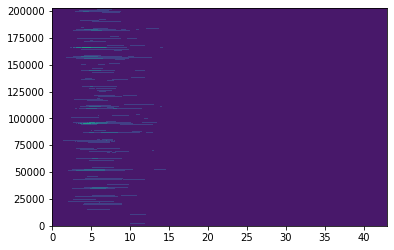

In [89]:
data = np.loadtxt("processedDataAll.txt")
plt.contourf(data)

## Toggle PCA

Principle Component Anaylsis can be used to precondtion the data. The goal is to remove some of the noise from the data so that the recurrent networks are easier to train.

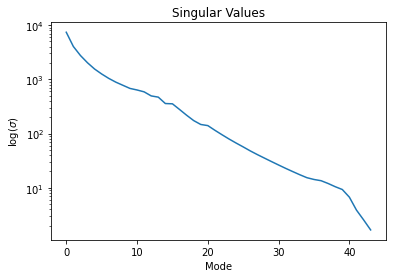

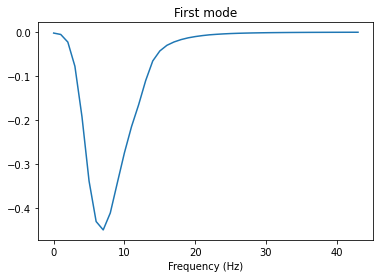

(202459, 44)


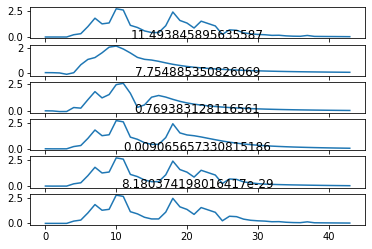

In [90]:
takePCA = True
if takePCA == True:
  averageSpectra = np.mean(data,axis = 0)
  meanSubtractedData = data-averageSpectra
  dataForSVD = meanSubtractedData.transpose()

  u,s,v = np.linalg.svd(dataForSVD,full_matrices = False)

  plt.semilogy(s)
  plt.title("Singular Values")
  plt.xlabel("Mode")
  plt.ylabel(r"$\log(\sigma)$")
  plt.show()


  plt.plot(u[:,0])
  plt.title("First mode")
  plt.xlabel("Frequency (Hz)")
  plt.show()

  figR, axR = plt.subplots(6)
  testSpectra =  meanSubtractedData[-1,:].transpose()
  axR[0].plot(averageSpectra+testSpectra)
  for i, n in enumerate([5, 10, 20, 30, 44]):
    reconstructedSpectra = averageSpectra + np.matmul(u[:, :n] ,np.dot(u[:, :n].transpose(),testSpectra ) )
    error = np.sum(((averageSpectra+testSpectra)-reconstructedSpectra)**2)
    axR[i+1].set_title("Reconstruction error with " + str(n) +" nodes: "error)
    axR[i+1].plot(reconstructedSpectra)
  figR.tight_layout()
  figR.show()

  # Suppose that we wish to represent the dataset in a lower dimension with 30 modes instead of 44
  nModes = 30
  reconstructedDataset = np.dot(u[:, :nModes] *s[:nModes], v[:nModes,:])
  data = reconstructedDataset.transpose()
  print(data.shape)

## Split into training data and validation data

The goal is to use the data from the previous 2 weeks to predict swell evolution over the next week.

We will use a sliding window approach. The input window will be 24*7*3 entries long. The output length will be 24*7 entries long. The window will slide along in a stride of 1 day (24 h).

The training data includes approximately 200,000 datapoints from 01/1996 to 04/2021. The test data is from the month of 05/2021.

### Generate input and target sequence

In [91]:
def split_data(data, inputSeqLen, outputSeqLen, stride):
  inputBegin = 0

  outputEnd = inputSeqLen + outputSeqLen


  inputOutputSequences = []

  while outputEnd < data.shape[0]:
   

    sequence = data[inputBegin:outputEnd,:]

  
    inputOutputSequences.append(sequence)

    inputBegin += stride

    outputEnd += stride

  return inputOutputSequences


inputSequenceLength = 24*7*2
outputSequenceLength = 24*7
stride = 24

inputOutputSequences = split_data(data, inputSequenceLength, outputSequenceLength, stride);

### Split the validation data and batch





In [92]:
totalSamples = len(inputOutputSequences)
trainingSamples = int(np.floor(totalSamples*0.8))
validationSamples = totalSamples-trainingSamples

IOSequencesTrain = inputOutputSequences[:trainingSamples]
IOSequencesVal = inputOutputSequences[trainingSamples:]


In [93]:
batchSize = 30 
trainLoader = DataLoader(IOSequencesTrain,
                         batch_size = batchSize,
                         collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

valLoader = DataLoader(IOSequencesVal,
                         batch_size = batchSize,
                         collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

completeTrainLoader = DataLoader(inputOutputSequences,
                         batch_size = batchSize,
                         collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
    



## Define Models

As we are doing time series prediction, we will use RNN architecture. We will use a many to many RNN, and specifically employ GRU to avoid the issue of vanishing gradients. Next, we will use a sequence to sequence model inspired by [G. Kumaran](https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60). This model builds on the GRU structure with an encoder and decoder.

### Vanilla GRU model



In [52]:
class GRUModel(nn.Module):
  def __init__(self, sequenceDimensions, inputSequenceLength, outputSeqLength, hiddenDim, GRUDepth):
    super(GRUModel,self).__init__()

    self.sequenceDimensions = sequenceDimensions
    self.inputSequenceLength = inputSequenceLength
    self.outputSeqLength = outputSeqLength
    self.hiddenDim = hiddenDim
    self.GRUDepth = GRUDepth


    self.gru = nn.GRU(input_size = self.sequenceDimensions, 
                      hidden_size = self.hiddenDim, 
                      num_layers = self.GRUDepth,
                      batch_first = True,
                      dropout = 0.3)
    self.linear1 = nn.Linear(self.hiddenDim, self.sequenceDimensions)
    self.linear2 = nn.Linear(self.inputSequenceLength, self.outputSeqLength)
    self.act = nn.ReLU()
    self.dropout = nn.Dropout(p=0.3)
    

  def forward(self, Xseq):
    
    # Perform the GRU
    out, _ = self.gru(Xseq) 

    # Fix dimensions of sequence (should be 44)
    out = self.linear1(out)
    out = self.act(out)
    out = self.dropout(out)


    # Reshape and fix sequence length
    out = out.reshape(Xseq.shape[0], self.sequenceDimensions, self.inputSequenceLength)
    out = self.linear2(out)

    # Reshape and return the final output
    out = out.reshape(Xseq.shape[0],self.outputSeqLength,self.sequenceDimensions)

    return out


### Seq2Seq

This model consists of an encoder, decoder, and wrapper

In [94]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, hiddenSize, inputSize):
    super(Seq2SeqEncoder,self).__init__()
    self.hiddenSize = hiddenSize

    self.gru = nn.GRU(
        num_layers = 1,
        input_size = inputSize,
        hidden_size = hiddenSize,
        batch_first = True)

  def forward(self,input):

    output, hidden = self.gru(input)
    return output, hidden
  


In [95]:
class Seq2SeqDecoder(nn.Module):
  def __init__(self, inputSize, hiddenSize):
    super(Seq2SeqDecoder, self).__init__()
    self.outputSize = 44
    self.inputSize = inputSize
    self.gruCell = nn.GRUCell(
        input_size = inputSize,
        hidden_size = hiddenSize)
    self.out = nn.Linear(hiddenSize, self.outputSize)
    self.dropout = nn.Dropout(0.2)
  
  def forward(self, previousHidden, y_i):
    rnnHidden = self.gruCell(y_i, previousHidden)
    output = self.out(rnnHidden) 
    return output, self.dropout(rnnHidden)



In [96]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoderCell,outputSize,teacherForcing,sequenceLength,device):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoderCell
    self.encoder.to(device)
    self.decoder.to(device)

    self.outputSize = outputSize
    self.teacherForcing = teacherForcing
    self.sequenceLength = sequenceLength
   

  def forward(self, Xb, yb =None):
   
    inputSeq = Xb
    encoderOutput, encoderHidden = self.encoder(inputSeq)
    
    previousHidden = encoderHidden.squeeze(0)
    outputs = torch.zeros(inputSeq.size(0), self.outputSize, inputSeq.size(-1), device = device)
    yPrev = inputSeq[:,-1,:] # The last timestep of the input sequence

    for i in range(self.outputSize):
      if (i>0) and (torch.rand(1)<self.teacherForcing) and (yb is not None):
        stepDecoderInput = yb[:,i,:].squeeze(1)
      else:
        stepDecoderInput = yPrev
      

      rnnOut, previousHidden = self.decoder(previousHidden,stepDecoderInput)
      yPrev = rnnOut


      outputs[:,i,:] = rnnOut.squeeze(1)
    return outputs
    

## Train the models

Functions to train the models are provided, followed by the code used to train on the training set. Validation is performed on the validation set.

In [53]:
def trainSeq2SeqModel(Seq2SeqEncoder,Seq2SeqDecoder,Seq2Seq,outputSequenceLength,
                      trainLoader,valLoader,epochs =50, finalTrain = False):
  hiddenSize = 88 # arbitrary
  outputSize = outputSequenceLength # the length of the output sequence to be created
  inputSize = 44 # The number of frequencies present



  encoder = Seq2SeqEncoder(hiddenSize, inputSize)
  decoder = Seq2SeqDecoder(inputSize, hiddenSize) 
  encoder.to(device)
  decoder.to(device)

  Model = Seq2Seq(encoder, decoder,outputSize, 0.2, inputSequenceLength, device)
  Model.to(device)

  criterion = nn.MSELoss()
  encoderOptimizer = optim.Adam(encoder.parameters(), lr=0.0001)
  decoderOptimizer = optim.Adam(decoder.parameters(), lr=0.0001)




  train_loss = []
  cv_loss = []


  for iteration in range(epochs):
    

    if iteration%5==0:   
      print("epoch ", iteration)
      print("-"*10)
      
    for i, batch in enumerate(trainLoader):
          
      batch = torch.stack(list(batch), dim=0).float()
      Xseq = batch[:,:inputSequenceLength,:]
      yseq = batch[:,inputSequenceLength:,:]

 
      Model.train()

      encoderOptimizer.zero_grad()  
      decoderOptimizer.zero_grad()           
      modelOut = Model(Xseq,yseq)

      
      
      # Change the loss to take care of smaller noise
      if iteration == 10:
        criterion = nn.L1Loss()

      loss = criterion(modelOut,yseq)

      

      loss.backward()

      encoderOptimizer.step()
      decoderOptimizer.step()
     

      train_loss.append(loss.item())

    if iteration%5==0:    
      print(f"\t train loss {loss.data:.4f}") 
      fig, ax = plt.subplots(2)
      p1 = ax[0].contourf(yseq[0,:,:].cpu(),cmap='viridis')
      ax[0].set_title("Actual")
      p2 = ax[1].contourf(modelOut[0,:,:].detach().cpu(),cmap='viridis')
      ax[1].set_title("Predicted")
      fig.colorbar(p1,ax = ax[0],ticks=[0, 5, 10])
      fig.colorbar(p2,ax = ax[1],ticks=[0, 5, 10])
      plt.show()
      plt.close(fig)

    if finalTrain !=True:
      with torch.no_grad():
        Model.eval()

        for data in valLoader:

          data = torch.stack(list(data), dim=0).float()
          Xseq = data[:,:inputSequenceLength,:]
          yseq = data[:,inputSequenceLength:,:]

          ypred =  Model(Xseq)
          loss_cv = criterion(ypred,yseq)
          cv_loss.append(loss_cv.item())

        if iteration%5==0:   
          print(f"\t cv loss {loss_cv.data:.4f}")
          fig, ax = plt.subplots(2)
          p1 = ax[0].contourf(yseq[0,:,:].cpu(),cmap='viridis')
          ax[0].set_title("Actual")
          p2 = ax[1].contourf(ypred[0,:,:].detach().cpu(),cmap='viridis')
          ax[1].set_title("Predicted")
          fig.colorbar(p1,ax = ax[0],ticks=[0, 5, 10])
          fig.colorbar(p2,ax = ax[1],ticks=[0, 5, 10])
          plt.show()
          plt.close(fig)


  fig,ax = plt.subplots(2)
  ax[0].plot(train_loss)
  ax[0].set_title("train")
  ax[1].plot(cv_loss)
  ax[1].set_title("val")
  plt.close(fig)

  return Model, train_loss, cv_loss

In [28]:
def trainGRUModel(GRUModel,trainLoader,valLoader,inputSequenceLength,outputSequenceLength,
                  epochs=50, finalTrain =False):
  Model = GRUModel(44,inputSequenceLength, outputSequenceLength, 160, 3)
  Model.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(Model.parameters(), lr=0.0001,weight_decay=1e-3)

  train_loss = []
  cv_loss = []
  for j in range(epochs):
    if j%10==0:   
      print("epoch ", j)
      print("-"*10)
      
    for i, data in enumerate(trainLoader):
          
      data = torch.stack(list(data), dim=0).float()
      Xseq = data[:,:inputSequenceLength,:]
      yseq = data[:,inputSequenceLength:,:]

      Model.train()

      optimizer.zero_grad()           
      rnnOut = Model(Xseq)

      # Change the criterion to take care of smaller errors
      if j == 10:
        criterion = nn.L1Loss()

      loss = criterion(rnnOut,yseq)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      
    if j%10==0:    
      print(f"\t train loss {loss.data:.4f}")

      fig, ax = plt.subplots(2)
      ax[0].contourf(yseq[0,:,:].cpu())
      ax[0].set_title("Actual")
      ax[1].contourf(rnnOut[0,:,:].detach().cpu())
      ax[1].set_title("Predicted")
      plt.show()

    if finalTrain !=True:
 
      with torch.no_grad():
        Model.eval()

        for data in valLoader:

          data = torch.stack(list(data), dim=0).float()
          Xseq = data[:,:inputSequenceLength,:]
          yseq = data[:,inputSequenceLength:,:]

          ypred =  Model(Xseq)
          loss_cv = criterion(ypred,yseq)
          cv_loss.append(loss_cv.item())

        if j%10==0:   
          print(f"\t cv loss {loss_cv.data:.4f}")

  fig,ax = plt.subplots(2)
  fig.subplots_adjust(top=0.8)

  ax[0].plot(train_loss)
  ax[0].set_title("Training Set")
  ax[1].plot(cv_loss)
  ax[1].set_title("Validation Set")
  ax[1].set_xlabel("Samples seen")
  
  
  fig.suptitle("GRU Loss Curves")
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()
  plt.close(fig)

  return Model, train_loss, cv_loss


epoch  0
----------
	 train loss 1.3537


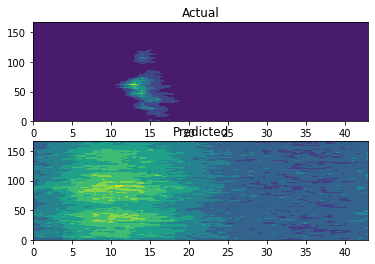

	 cv loss 3.8748
epoch  10
----------
	 train loss 0.4371


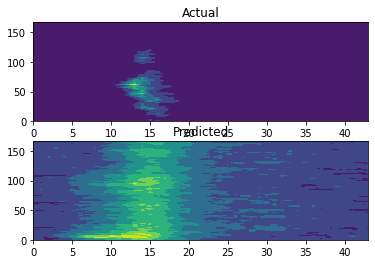

	 cv loss 0.4811
epoch  20
----------
	 train loss 0.4157


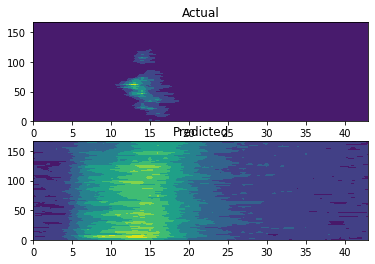

	 cv loss 0.4814
epoch  30
----------
	 train loss 0.4000


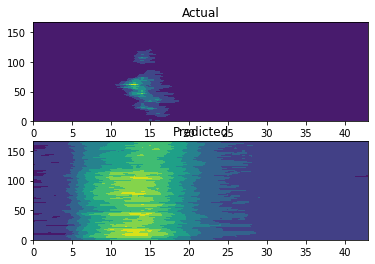

	 cv loss 0.4954
epoch  40
----------
	 train loss 0.3890


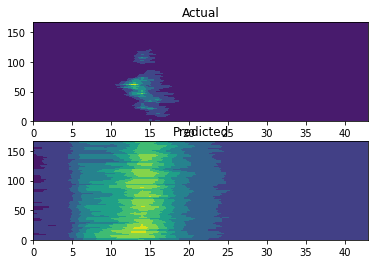

	 cv loss 0.4974


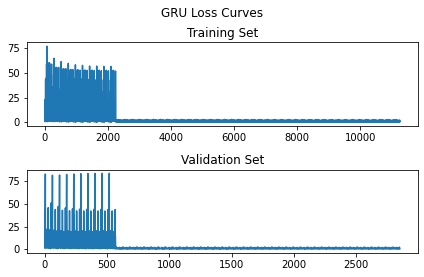

In [30]:
GRUModelTrained, train_loss_gru, cv_loss_gru = trainGRUModel(GRUModel,trainLoader,valLoader,inputSequenceLength,outputSequenceLength,epochs = 50, finalTrain = False)

epoch  0
----------
	 train loss 0.9729


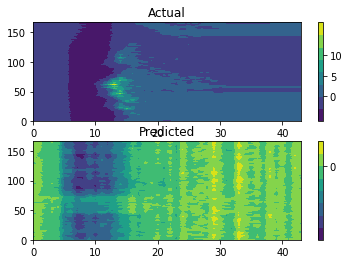

	 cv loss 5.3030


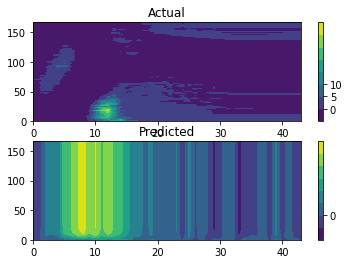

epoch  5
----------
	 train loss 0.5711


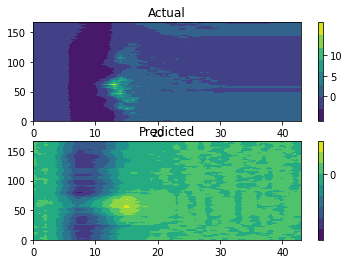

	 cv loss 6.9606


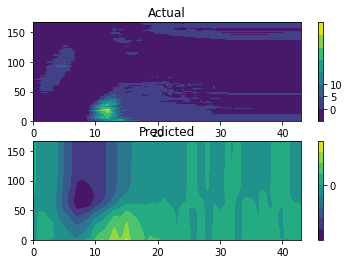

epoch  10
----------
	 train loss 0.3214


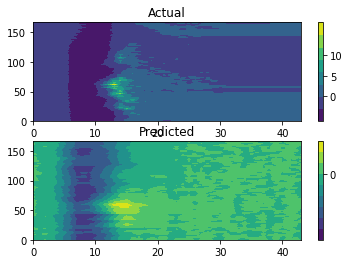

	 cv loss 0.4292


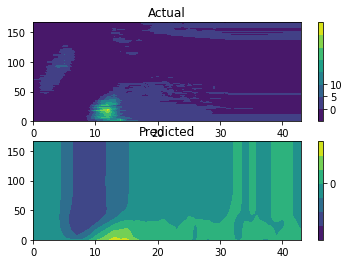

epoch  15
----------
	 train loss 0.2808


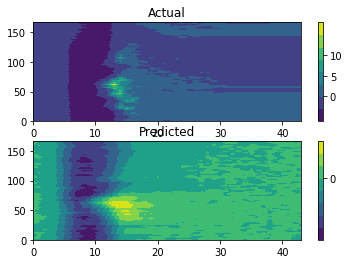

	 cv loss 0.4328


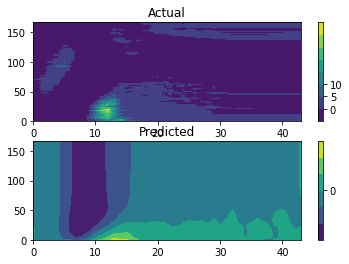

epoch  20
----------
	 train loss 0.2865


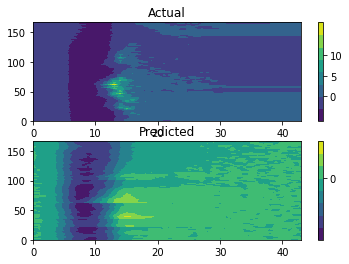

	 cv loss 0.4280


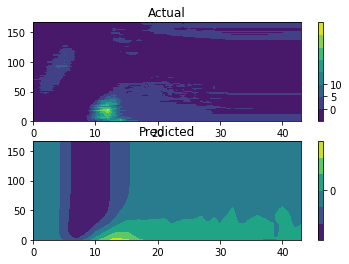

epoch  25
----------
	 train loss 0.2491


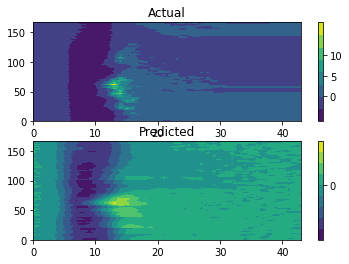

	 cv loss 0.4283


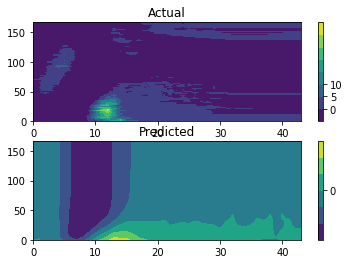

epoch  30
----------
	 train loss 0.2446


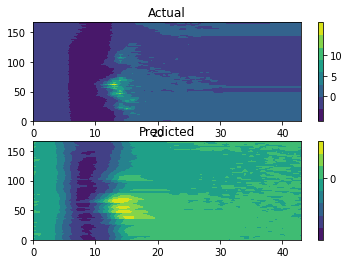

	 cv loss 0.4243


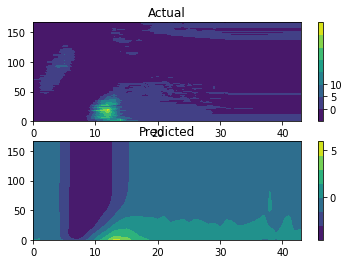

epoch  35
----------
	 train loss 0.2325


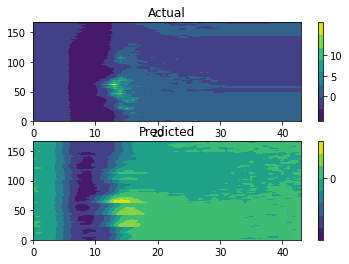

	 cv loss 0.4351


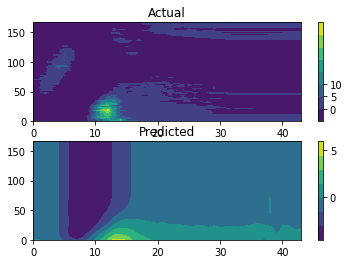

epoch  40
----------
	 train loss 0.2321


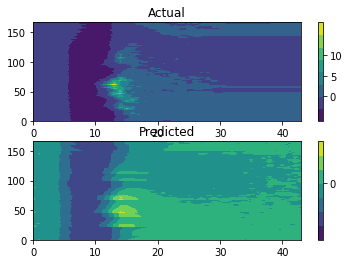

	 cv loss 0.4275


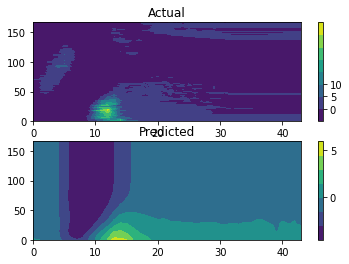

epoch  45
----------
	 train loss 0.2189


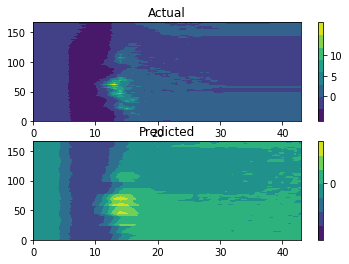

	 cv loss 0.4388


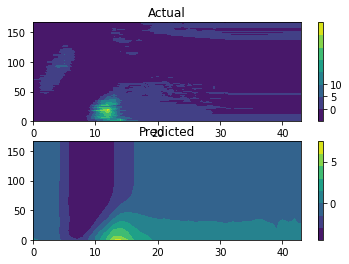

In [54]:
ssModelTrained_p, train_loss_ss_p, cv_loss_ss_p =  trainSeq2SeqModel(Seq2SeqEncoder,Seq2SeqDecoder,Seq2Seq,outputSequenceLength,
                      trainLoader,valLoader,epochs =50, finalTrain = False)

## Test the model

The model is tested on the last month of data available, from the month of 05/2021.

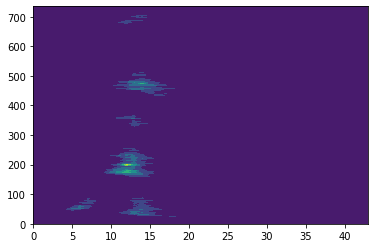

In [102]:
testdata = np.loadtxt("processedDataTest.txt")
plt.contourf(testdata)

As before, PCA can be taken if desired. This should be done only if the model was trained on the preconditioned data.

In [109]:
if takePCA==True:

  meanSubtractedDataTest = testdata-averageSpectra
  dataForSVDTest = meanSubtractedDataTest.transpose()

  ut,st,vt = np.linalg.svd(dataForSVDTest,full_matrices = False)
  nModes = 30
  reconstructedDatasetTest = np.dot(ut[:, :nModes] *st[:nModes], vt[:nModes,:])
  testdata = reconstructedDatasetTest.transpose()
  print(testdata.shape)

(736, 44)


Load the training data into a data loader

In [110]:
inputOutputSequencesTest = split_data(testdata, inputSequenceLength, outputSequenceLength, stride);
testLoader = DataLoader(inputOutputSequencesTest,
                         batch_size = 1,
                         collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

### First, train all models on *all* training data

In [ ]:
FinalGRUModelTrained, _, _ = trainGRUModel(GRUModel,completeTrainLoader,valLoader,inputSequenceLength,outputSequenceLength,epochs = 50, finalTrain = True)

In [ ]:
FinalssModelTrained, _, _ =  trainSeq2SeqModel(Seq2SeqEncoder,Seq2SeqDecoder,Seq2Seq,outputSequenceLength,
                      completeTrainLoader,valLoader,epochs =50, finalTrain = True)

### Next, evaluate the model on the test data

The loss is printed at the bottom of the cell. Predicitons of all 10 test samples are plotted.

#### GRU


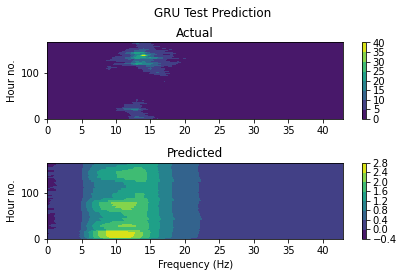

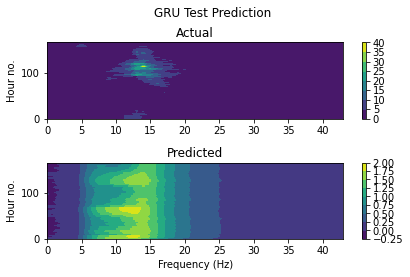

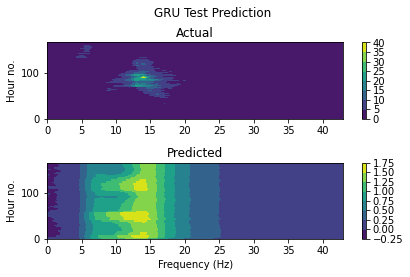

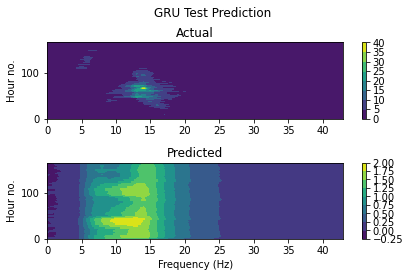

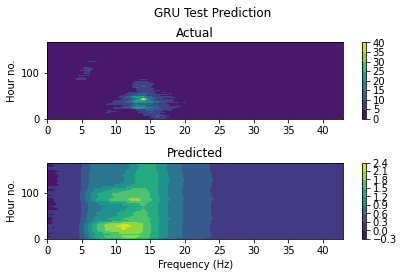

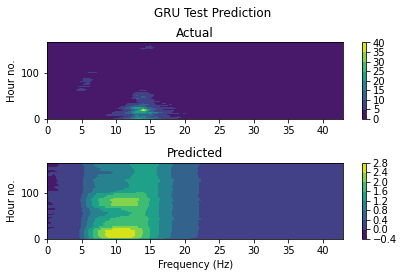

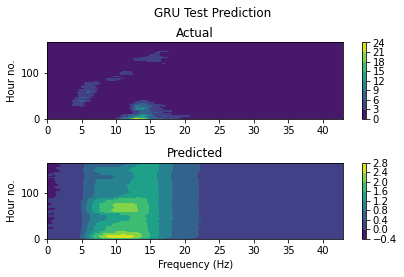

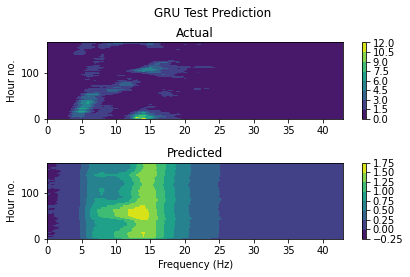

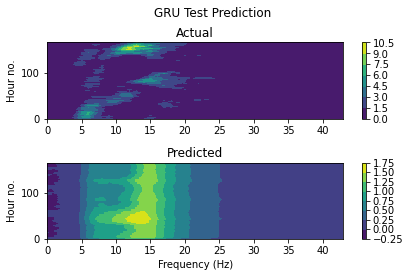

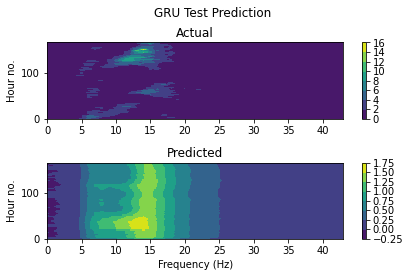

0.6279746472835541


In [104]:
criterion = nn.L1Loss()
test_loss = []

with torch.no_grad():
  FinalGRUModelTrained.eval()
  j=0
  for i,data in enumerate(testLoader):

    data = torch.stack(list(data), dim=0).float()
    Xseq = data[:,:inputSequenceLength,:]
    yseq = data[:,inputSequenceLength:,:]

    ypred =  FinalGRUModelTrained(Xseq)
    loss_test = criterion(ypred,yseq)
    test_loss.append(loss_test.item())

   

    fig, ax = plt.subplots(2)
    p1 = ax[0].contourf(yseq[0,:,:].cpu(),cmap='viridis')
    ax[0].set_title("Actual")
    ax[0].set_ylabel("Hour no.")
    p2 = ax[1].contourf(ypred[0,:,:].detach().cpu(),cmap='viridis')
    ax[1].set_title("Predicted")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Hour no.")
    fig.colorbar(p1,ax = ax[0])
    fig.colorbar(p2,ax = ax[1])
    fig.suptitle("GRU Test Prediction")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close(fig)


print(np.mean(test_loss))

#### Seq2Seq

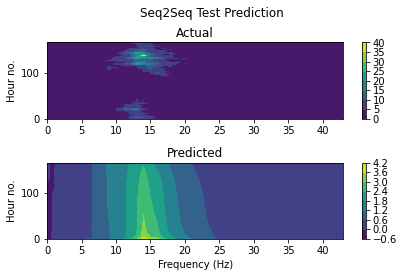

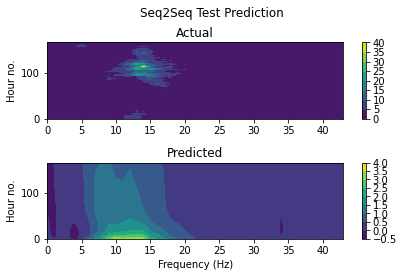

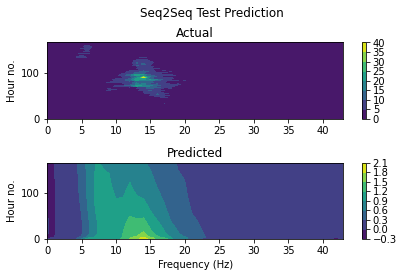

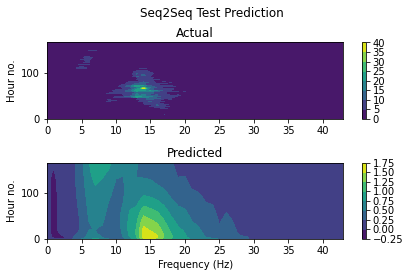

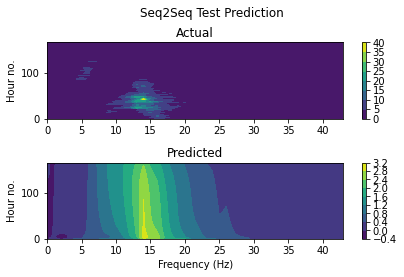

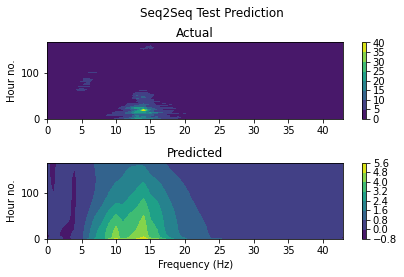

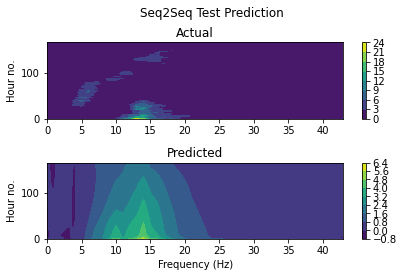

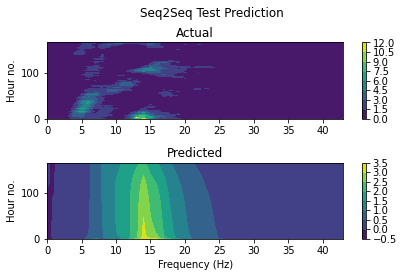

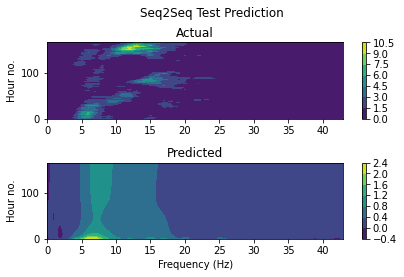

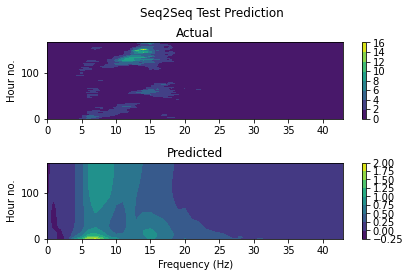

0.6586916029453278


In [105]:
criterion = nn.L1Loss()
test_loss = []
with torch.no_grad():
  FinalssModelTrained.eval()
  j=0
  for i,data in enumerate(testLoader):

    data = torch.stack(list(data), dim=0).float()
    Xseq = data[:,:inputSequenceLength,:]
    yseq = data[:,inputSequenceLength:,:]

    ypred =  FinalssModelTrained(Xseq)
    loss_test = criterion(ypred,yseq)
    test_loss.append(loss_test.item())


    fig, ax = plt.subplots(2)
    p1 = ax[0].contourf(yseq[0,:,:].cpu(),cmap='viridis')
    ax[0].set_title("Actual")
    ax[0].set_ylabel("Hour no.")
    p2 = ax[1].contourf(ypred[0,:,:].detach().cpu(),cmap='viridis')
    ax[1].set_title("Predicted")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Hour no.")
    fig.colorbar(p1,ax = ax[0])
    fig.colorbar(p2,ax = ax[1])
    fig.suptitle("Seq2Seq Test Prediction")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close(fig)


print(np.mean(test_loss))

## Conclusions

All the models performed similarly, but the Seq2Seq models qualitatively performed better. 

To improve predictive power, more data should be fed to the model, such as meterological data collected at the buoy. However, because swell is a global phenomenon, ideally global data should be incorporated into the prediciton model.